__Chapter 5 - Compressing Data via Dimensionality Reduction__

1. [Import](#Import)
1. [Unsupervised dimensionality reduction via principal component analysis](#Unsupervised-dimensionality-reduction-via-principal-component-analysis)
    1. [Covariance matrix, eigenvalues, eigenvectors](#Covariance-matrix-eigenvalues-eigenvectors)
    1. [Total and explained variance](#Total-and-explained-variance)
    1. [Feature transformation](#Feature-transformation)
    1. [Principal component analysis in scikit-learn](#Principal-component-analysis-in-scikit-learn)
1. [Supervised data compression via linear discriminant analysis](#Supervised-data-compression-via-linear-discriminant-analysis)
    1. [Computing the scatter matrices](#Computing-the-scatter-matrices)
    1. [Selecting linear discriminants for the new feature subspace](#Selecting-linear-discriminants-for-the-new-feature-subspace)
    1. [Projecting samples onto the new feature space](#Projecting-samples-onto-the-new-feature-space)
    1. [LDA in scikit-learn](#LDA-in-scikit-learn)


# Import

<a id = 'Import'></a>

In [1]:
# standard libary and settings
import os
import sys
import importlib
import itertools
from io import StringIO
import warnings

warnings.simplefilter("ignore")
from IPython.core.display import display, HTML

display(HTML("<style>.container { width:95% !important; }</style>"))

# data extensions and settings
import numpy as np

np.set_printoptions(threshold=np.inf, suppress=True)
import pandas as pd

pd.set_option("display.max_rows", 500)
pd.options.display.float_format = "{:,.6f}".format

# modeling extensions
import sklearn.base as base
import sklearn.cluster as cluster
import sklearn.datasets as datasets
import sklearn.decomposition as decomposition
import sklearn.ensemble as ensemble
import sklearn.feature_extraction as feature_extraction
import sklearn.feature_selection as feature_selection
import sklearn.linear_model as linear_model
import sklearn.metrics as metrics
import sklearn.model_selection as model_selection
import sklearn.neighbors as neighbors
import sklearn.pipeline as pipeline
import sklearn.preprocessing as preprocessing
import sklearn.svm as svm
import sklearn.tree as tree
import sklearn.discriminant_analysis as discriminant_analysis

# visualization extensions and settings
import seaborn as sns
import matplotlib.pyplot as plt

# custom extensions and settings
sys.path.append("/home/mlmachine") if "/home/mlmachine" not in sys.path else None
sys.path.append("/home/prettierplot") if "/home/prettierplot" not in sys.path else None

import mlmachine as mlm
from prettierplot.plotter import PrettierPlot
import prettierplot.style as style

# magic functions
%matplotlib inline

/usr/local/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


# Unsupervised dimensionality reduction via principal component analysis

Feature extraction techniques are useful for reducing the number of features in a dataset. Feature extraction can be thought of data compression completed in a way that strives to maintain most of the relevant information. It improves storage space and computational efficiency, and may even improve predictive power by combating the curse of dimensionality.

Principal component analysis (PCA) is a feature extraction technique. It is an unsupervised linear transformation method that identifies patterns in data based on the correlation between features. It aims to find the directions of maximum variance in high-dimensional data and projects it onto a new feature subspace. the principal components are orthogonal and can be interpreted as the directions of maximum variance.

We construct a $d$ x $k$ - dimensional transformation matrix $\textbf{W}$ that enables us to map a sample vector $\textbf{x}$ onto a new $k$-dimensional feature subspace with fewer dimensions than the original $d$-dimensioanl feature space:

$$
\textbf{x} = [x_1,x_2,...,x_d], \textbf{x} \in \mathbb{R}^d
$$

$$
\downarrow \textbf{xW}, \textbf{W} \in \mathbb{R}^{dxk}
$$

$$
\textbf{z} = [x_1,x_2,...,z_d], \textbf{z} \in \mathbb{R}^k
$$

In the resulting vector $\textbf{z}$, the first principal component will have the largest possible variance, and the subsequent principal components will have the largest variance given the constraint that these components are uncorrelated/orthogonal to the other principal components. Feature scaling is essential to perform prior to using PCA. Here are the keys steps:

1. Standardize the $d$-dimensional dataset
2. Create a covariance matrix
3. Decompose covariance matrix into its eigenvectors and eigenvalues
4. Sort the eigenvalues by decreasing order to rank the corresponding eigenvectors
5. Select $k$ eigenvectors which correspond to the $k$ largest eigenvalues, where $k$ is the desired dimensionality of the new feature subspace 
6. Construct a projection matrix $\textbf{W}$ using the top $k$ eigenvectors
7. Transform the $d$-dimensional dataset $\textbf{X}$ using the projection matrix $\textbf{W}$ to obtain the new $k$-dimensional feature subspace.

<a id = 'Unsupervised-dimensionality-reduction-via-principal-component-analysis'></a>

In [2]:
# load and inspect wine data
wine_data = datasets.load_wine()
df_wine = pd.DataFrame(
    data=np.c_[wine_data.target, wine_data.data],
    columns=["class labels"] + wine_data.feature_names,
)
df_wine[:5]

,class labels,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,0.000000,14.230000,1.710000,2.430000,15.600000,127.000000,2.800000,3.060000,0.280000,2.290000,5.640000,1.040000,3.920000,"1,065.000000"
1,0.000000,13.200000,1.780000,2.140000,11.200000,100.000000,2.650000,2.760000,0.260000,1.280000,4.380000,1.050000,3.400000,"1,050.000000"
2,0.000000,13.160000,2.360000,2.670000,18.600000,101.000000,2.800000,3.240000,0.300000,2.810000,5.680000,1.030000,3.170000,"1,185.000000"
3,0.000000,14.370000,1.950000,2.500000,16.800000,113.000000,3.850000,3.490000,0.240000,2.180000,7.800000,0.860000,3.450000,"1,480.000000"
4,0.000000,13.240000,2.590000,2.870000,21.000000,118.000000,2.800000,2.690000,0.390000,1.820000,4.320000,1.040000,2.930000,735.000000


## Covariance matrix, eigenvalues, eigenvectors

<a id = 'Covariance-matrix-eigenvalues-eigenvectors'></a>

In [3]:
# split and standardize data
X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=0
)

sc = preprocessing.StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

After standardizing the data, the next step is to create the covariance matrix. This is a $d$ x $d$ dimensional matrix, where $d$ is the number of features in the full dataset. The matrix stores the pairwise covariances between the features. For example, the covariance between two features $\textbf{x}_j$ and $\textbf{x}_k$ can be calculated with this equation:

$$
\sigma_{jk} = \frac{1}{n}\sum^n_{i=1}\big(x_j^{(i)} - \mu_j\big)\big(x_k^{(i)} - \mu_k\big)
$$

$\mu_j$ and $\mu_k$ are the sample means of features $j$ and $k$. Standardizing the data make it so that the samples are equal to 0, so if the covariance is positive, that means the features increase or decrease together, and if the covariance is negative, the features vary in opposite directions.

$$
\Sigma = \begin{bmatrix}
    \sigma_1^2 & \sigma_{12} & \sigma_{13} \\
    \sigma_{21} & \sigma_2^2 & \sigma_{23} \\
    \sigma_{31} & \sigma_{32} & \sigma_3^2 \\
\end{bmatrix}
$$

The eigenvectors of the covariance matrix represent the principal components, and the corresponding eigenvalues define the eigenvectors magnitude. The wine dataset in this exmaple will yield a 13 x 13 dimensional covariance matrix and 13 eigenvectors and eigenvalues.

$$
\Sigma\textbf{v} = \lambda\textbf{v}
$$

$\textbf{v}$ is an eigenvector and $\lambda$ is an eigenvalue. So multiplying the covariance matrix $\Sigma$ by an eigenvector is equal to an eigenvalue multiplied by its corresponding eigenvector

In [4]:
# caculate covariance matrix and its eigenvalues and eigenvectors
cov_mat = np.cov(X_train_std.T)
print("Covariance matrix shape: {0} \n".format(cov_mat.shape))

eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)
print("Eigenvalues: {0}".format(eigen_vals))

Covariance matrix shape: (13, 13) 

Eigenvalues: [4.84274532 2.41602459 1.54845825 0.96120438 0.84166161 0.6620634
 0.51828472 0.34650377 0.3131368  0.10754642 0.21357215 0.15362835
 0.1808613 ]


## Total and explained variance

We want to select a subset of the eigevectors(principal components) that contains the most information (variance). The eigenvalues define the magnitude of the eigenvectors, so we need to sort the eigenvalues in order of decreasing magnitude. We want the top $k$ eigenvectors based on the sorted eigenvalues. 

We can also plot the variance explained ratios of the eigenvalues. The variance explained ratio of an eigenvalue $\lambda_j$ is the fraction of the eigenvalue $\lambda_j$ and the total sum of the eigvalues:

$$
\frac{\lambda_j}{\sum^d_{j=1}\lambda_j}
$$


<a id = 'Total-and-explained-variance'></a>

In [5]:
# calculate total variance and explained variance
total = sum(eigen_vals)
var_exp = [(i / total) for i in sorted(eigen_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

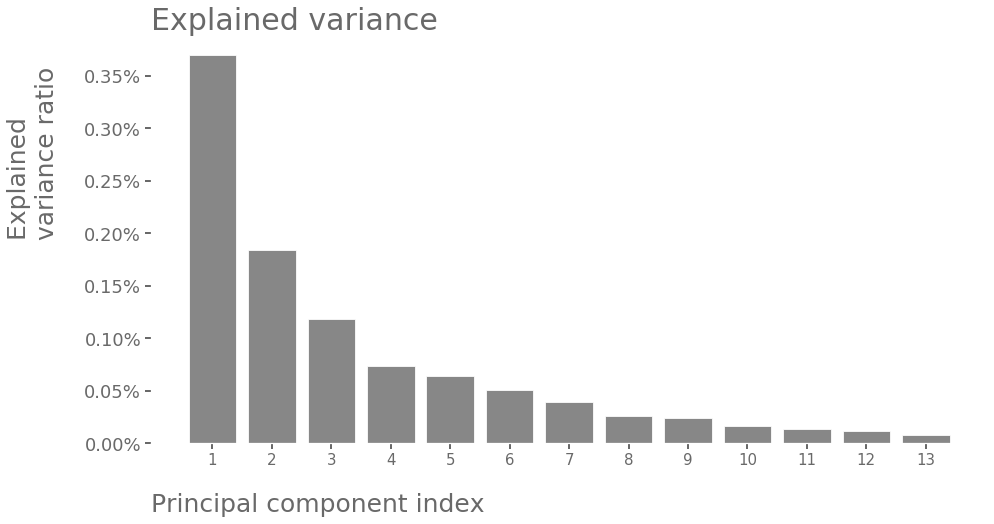

In [6]:
#  visualize explained variance by principal component
p = PrettierPlot()
ax = p.make_canvas(
    title="Explained variance",
    x_label="Principal component index",
    y_label="Explained \nvariance ratio",
    y_shift=0.5,
)
p.pretty_bar_v(
    x=np.arange(1, len(var_exp) + 1),
    counts=var_exp,
    x_labels=np.arange(1, len(var_exp) + 1),
    label_rotate=0,
    y_units="ppp",
    ax=ax,
)

> Remarks - The first principal component accounts for over 35% of the variance by itself. The first three account for nearly 70%

## Feature transformation

With the eigenvalue/eigenvector pairs in hands, we need to transform the dataset onto the new principal component axes.

We need to sort the eigenpairs by descending order of the eigenvalues, create a projection matrix from the selected eigenvectors, and use the projection matrix to transform the data onto the lower-dimensional subspace/

<a id = 'Feature-transformation'></a>

In [7]:
# create and sort eigen_ pairs
eigen_pairs = [
    (np.abs(eigen_vals[i]), eigen_vecs[:, i]) for i in range(len(eigen_vals))
]
eigen_pairs.sort(key=lambda k: k[0], reverse=True)

# print first couple eigen pairs
eigen_pairs[:2]

[(4.8427453156558915,
  array([-0.13724218,  0.24724326, -0.02545159,  0.20694508, -0.15436582,
         -0.39376952, -0.41735106,  0.30572896, -0.30668347,  0.07554066,
         -0.32613263, -0.36861022, -0.29669651])),
 (2.4160245870352246,
  array([ 0.50303478,  0.16487119,  0.24456476, -0.11352904,  0.28974518,
          0.05080104, -0.02287338,  0.09048885,  0.00835233,  0.54977581,
         -0.20716433, -0.24902536,  0.38022942]))]

In [8]:
# create projection matrix for top 2 principal components
w = np.hstack((eigen_pairs[0][1][:, np.newaxis], eigen_pairs[1][1][:, np.newaxis]))
print("Matrix W: \n {}".format(w))

Matrix W: 
 [[-0.13724218  0.50303478]
 [ 0.24724326  0.16487119]
 [-0.02545159  0.24456476]
 [ 0.20694508 -0.11352904]
 [-0.15436582  0.28974518]
 [-0.39376952  0.05080104]
 [-0.41735106 -0.02287338]
 [ 0.30572896  0.09048885]
 [-0.30668347  0.00835233]
 [ 0.07554066  0.54977581]
 [-0.32613263 -0.20716433]
 [-0.36861022 -0.24902536]
 [-0.29669651  0.38022942]]


The projection matrix can be used to transform a sample $\textbf{x}$ onto the PCA subspace to obtain $\textbf{x'}$

$$
\textbf{x'} = \textbf{x}\textbf{W}
$$

In [9]:
# transform single sample
X_train_std[0].dot(w)

array([2.38299011, 0.45458499])

The projection matrix can also be used to transform the full data set

$$
\textbf{X'} = \textbf{X}\textbf{W}
$$

In [10]:
# transform single sample, print top 5 rows
X_train_pca = X_train_std.dot(w)
X_train_pca[:5]

array([[ 2.38299011,  0.45458499],
       [-1.96578183,  1.65376939],
       [-2.53907598,  1.02909066],
       [-1.43010776,  0.6024011 ],
       [ 3.14147227,  0.66214979]])

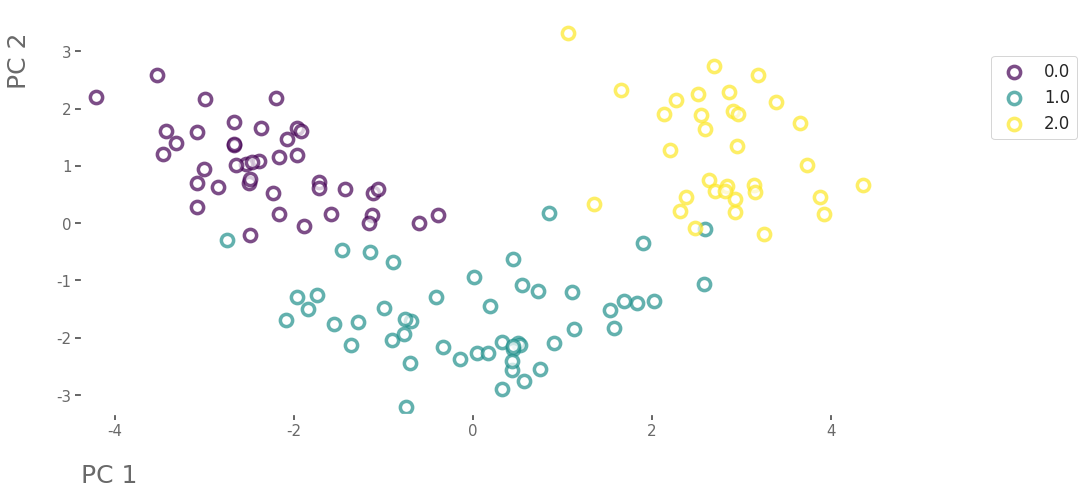

In [11]:
# visualize labeled data when distilled down to top 2 principal components
p = PrettierPlot()
ax = p.make_canvas(title="", x_label="PC 1", y_label="PC 2", y_shift=0.8)
p.pretty_2d_scatter_hue(
    x=X_train_pca[:, 0],
    y=X_train_pca[:, 1],
    target=y_train,
    label=np.unique(y_train),
    x_units="f",
    y_units="f",
    ax=ax,
)

> Remarks - The above visual is encoded with the class labels but it's important to note that PCA is an unsupervised method. 

## Principal component analysis in scikit-learn

<a id = 'Principal-component-analysis-in-scikit-learn'></a>

In [13]:
# perform PCA on wine dataset, create logistic regression
# model with first two principal components
pca = decomposition.PCA(n_components=2)
lr = linear_model.LogisticRegression()
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

lr.fit(X_train_pca, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

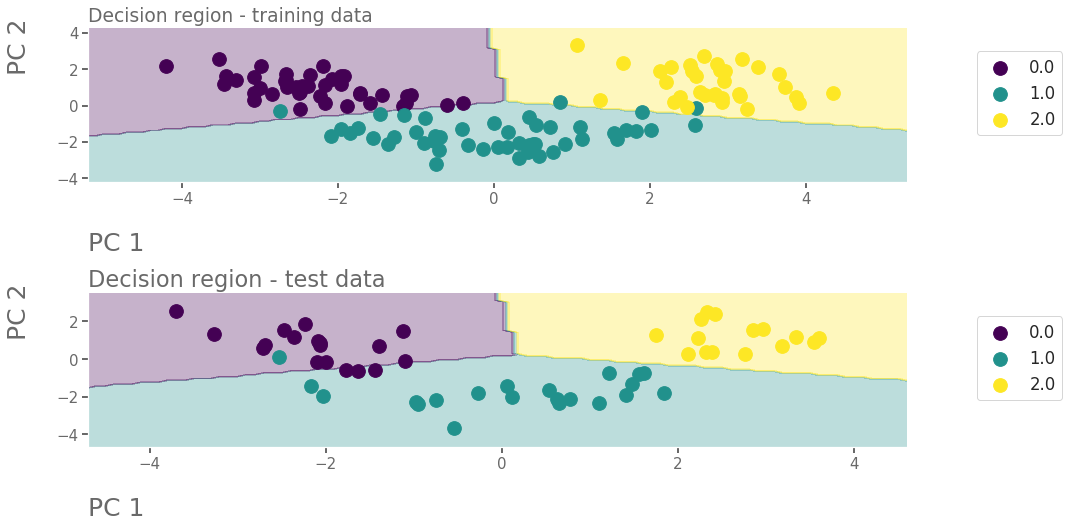

In [14]:
# plot PCA decision region
p = PrettierPlot()
ax = p.make_canvas(
    title="Decision region - training data",
    x_label="PC 1",
    y_label="PC 2",
    y_shift=0.7,
    position=211,
)
p.pretty_decision_region(x=X_train_pca, y=y_train, classifier=lr, ax=ax)
ax = p.make_canvas(
    title="Decision region - test data",
    x_label="PC 1",
    y_label="PC 2",
    y_shift=0.7,
    position=212,
)
p.pretty_decision_region(x=X_test_pca, y=y_test, classifier=lr, ax=ax)

> Remarks - The performance of the train and test sets is comparable. It appears that a handful of samples from the blue and green classes are borderline cases that are misclassified based on our two principal components.

In [15]:
# evaluate explained variance ratios using scikit-learn
pca = decomposition.PCA(n_components=None)
X_train_pca = pca.fit_transform(X_train_std)
pca.explained_variance_ratio_

array([0.36951469, 0.18434927, 0.11815159, 0.07334252, 0.06422108,
       0.05051724, 0.03954654, 0.02643918, 0.02389319, 0.01629614,
       0.01380021, 0.01172226, 0.00820609])

# Supervised data compression via linear discriminant analysis

Linear discriminant analysis (LDA) is another feature extraction technique that can be useful for reducing overfitting due to the curse of dimensionality and increasing computational efficiency.

PCA is unsupervised, whereas LDA is supervised. LDA strives to find the feature subspace that optimizes class separability. It assumes that data is normally distributed, the classes have identical covariance matrices, and the features are statistically independent of each other.

A linear discriminant is a feature that effectively separates classes, as opposed to capturing the variance in the dataset. The class-discriminatory information is most important in LDA. Here are the keys steps:

1. Standardize the $d$-dimensional dataset
2. For each class, compute the $d$-dimensional mean vector
3. Construcuter the between-class scatter matrix $\textbf{S}_B$ and the within-class scatter matrix $\textbf{S}_w$
4. Computer the eigenvectors and eigenvalues of the matrix $\textbf{S}_w^{-1}$$\textbf{S}_B$
5. Sort the eigenvalues by decreasing order to rank the corresponding eigenvectors.
6. Choose the $k$ eigenvectors that correspond to the $k$ largest eigenvalues to construct a $d$ x $k$-dimensional transformation matrix $\textbf{W}$. The selected eigenvectors are the columns in this matrix
7. Project the samples onto the new feature subspace using the transformation matrix $\textbf{W}$

PCA and LDA both involve the decomposition of matrices into eigenvalues and eigenvectors. LDA also includes class information, which is represented by the mean vectors described in step 2.

<a id = 'Supervised-data-compression-via-linear-discriminant-analysis'></a>

## Computing the scatter matrices

The precursor to computing the scatter matrices is calculating the mean vectors for each class. In the case of the wine dataset, we will get 3 mean vectors. 

Each mean vectors $\textbf{m}_i$ stores the mean feature value $\mu_m$ with respect to the samples of class $i$:

$$
\textbf{m} = \frac{1}{n}\sum^c_{X \in D_i}\textbf{x}_m
$$

This create three mean vectors:

$$
\textbf{m}_i = \begin{bmatrix}
    \mu_{i,alcohol} \\
    \mu_{i,malic acid} \\
    ... \\
    \mu_{i,proline} \\
\end{bmatrix} i \in [1,2,3]
$$


<a id = 'Computing the scatter matrices'></a>

In [16]:
# calculate mean vectors for each class
np.set_printoptions(precision=4)
mean_vecs = []
for label in np.unique(y_train):
    mean_vecs.append(np.mean(X_train_std[y_train == label], axis=0))
    print("Mean vector, class {0}: {1} \n".format(label, mean_vecs[int(label)]))

Mean vector, class 0.0: [ 0.9066 -0.3497  0.3201 -0.7189  0.5056  0.8807  0.9589 -0.5516  0.5416
  0.2338  0.5897  0.6563  1.2075] 

Mean vector, class 1.0: [-0.8749 -0.2848 -0.3735  0.3157 -0.3848 -0.0433  0.0635 -0.0946  0.0703
 -0.8286  0.3144  0.3608 -0.7253] 

Mean vector, class 2.0: [ 0.1992  0.866   0.1682  0.4148 -0.0451 -1.0286 -1.2876  0.8287 -0.7795
  0.9649 -1.209  -1.3622 -0.4013] 



The mean vectors can be used to compute the within-class scatter matrix $\textbf{S}_w$:

$$
\textbf{S}_w = \sum^c_{i = 1}\textbf{S}_i
$$

This is calculated by summing the individual scatter matrices $\textbf{S}_i$ for each individual class $i$:

$$
\textbf{S}_i = \sum^c_{x \in D_i}(\textbf{x} - \textbf{m}_i)(\textbf{x} - \textbf{m}_i)^T
$$


In [17]:
# calculate the within-class scatter matrix
d = X_train_std.shape[1]
Sw = np.zeros((d, d))
for label, mv in zip(np.unique(y_train), mean_vecs):
    class_scatter = np.zeros((d, d))
    for row in X_train_std[y_train == label]:
        row, mv = row.reshape(d, 1), mv.reshape(d, 1)
        class_scatter += (row - mv).dot((row - mv).T)
    Sw += class_scatter

print("Within-class scatter matrix shape: {}".format(Sw.shape))

Within-class scatter matrix shape: (13, 13)


In [18]:
# class value counts
values, counts = np.unique(y_train, return_counts=True)
print("Class distribution: {}".format(counts))

Class distribution: [41 50 33]


One of the assumptions for computing the scatter matrices is that the class labels are uniformly distributed. This is clearly being violated based on the code above. To accommodate that, we need to scale the individual scatter matrices $\textbf{S}_i$ before summing up to form the scatter matrix $\textbf{S}_w$. When dividing the scatter matrices by the number of class samples $n_i$, it's apparent that the scatter matrix is the same as computing the covariance matrix $\Sigma_i$. The covariance matrix is a normalized version of the scatter matrix

$$
\Sigma_i = \frac{1}{n_i}\textbf{S}_w = \frac{1}{n_i}\sum^c_{x \in D_i}(\textbf{x} - \textbf{m}_i)(\textbf{x} - \textbf{m}_i)^T
$$


In [19]:
# calculate the scaled within-class scatter matrix
d = X_train_std.shape[1]
Sw = np.zeros((d, d))
for label, mv in zip(np.unique(y_train), mean_vecs):
    class_scatter = np.cov(X_train_std[y_train == label].T)
    Sw += class_scatter

print("Scaled within-class scatter matrix shape: {}".format(Sw.shape))

Scaled within-class scatter matrix shape: (13, 13)


Next, we need to compute the between-class scatter matrix $\textbf{S}_B$

$$
\textbf{S}_B = \sum^c_{i = 1}n_i(\textbf{m}_i - \textbf{m})(\textbf{m}_i - \textbf{m})^T
$$

where $\textbf{m}$ is the overall mean that is computed, including samples from all classes.

In [20]:
# compute within-class scatter matrix
mean_overall = np.mean(X_train_std, axis=0)
d = X_train_std.shape[1]
Sb = np.zeros((d, d))
for i, mean_vec in enumerate(mean_vecs):
    n = X_train[y_train == i, :].shape[0]
    mean_vec = mean_vec.reshape(d, 1)
    mean_overall = mean_overall.reshape(d, 1)
    Sb += n * (mean_vec - mean_overall).dot((mean_vec - mean_overall).T)

print("Scaled within-class scatter matrix shape: {}".format(Sb.shape))

Scaled within-class scatter matrix shape: (13, 13)


## Selecting linear discriminants for the new feature subspace

With PCA, we perform an eigendecomposition on the covariance matrix. With LDA, we solve the generalized eigenvalue problem of the matrix $\textbf{S}_w^{-1}\textbf{S}_B$.

With the eigenpairs in hand, we can now sort the eigenvalues in descending order, and retrieve the corresponding eigenvectors.

<a id = 'Selecting-linear-discriminants-for-the-new-feature-subspace'></a>

In [20]:
# calculate eigenvalues and eigenvectors
eigen_vals, eigen_vecs = np.linalg.eig(np.linalg.inv(Sw).dot(Sb))

eigen_pairs = [
    (np.abs(eigen_vals[i]), eigen_vecs[:, i]) for i in range(len(eigen_vals))
]
eigen_pairs = sorted(eigen_pairs, key=lambda k: k[0], reverse=True)

print("Eigenvalues in descending order: \n")
for eigen_val in eigen_pairs:
    print(eigen_val[0])

Eigenvalues in descending order: 

349.61780890599397
172.7615221897938
3.2408058667989877e-14
2.842170943040401e-14
2.525003131722881e-14
2.525003131722881e-14
1.7305705389846235e-14
1.7011368381160403e-14
1.4465403123928443e-14
1.4465403123928443e-14
4.462490677759783e-15
4.462490677759783e-15
3.7872569513332085e-15


The number of linear discriminants in LDA is at most $c$-1, where $c$ is the number of class labels. This is clear by reviewing the eigenvalues above. Only two are non-zero (3 - 13 are very, very close to zero).

To measure how much of the class-discriminatory information is cpatured by the linear discriminants(eigenvectors), we can plot the explained variance, similar to what was performed for PCA above.

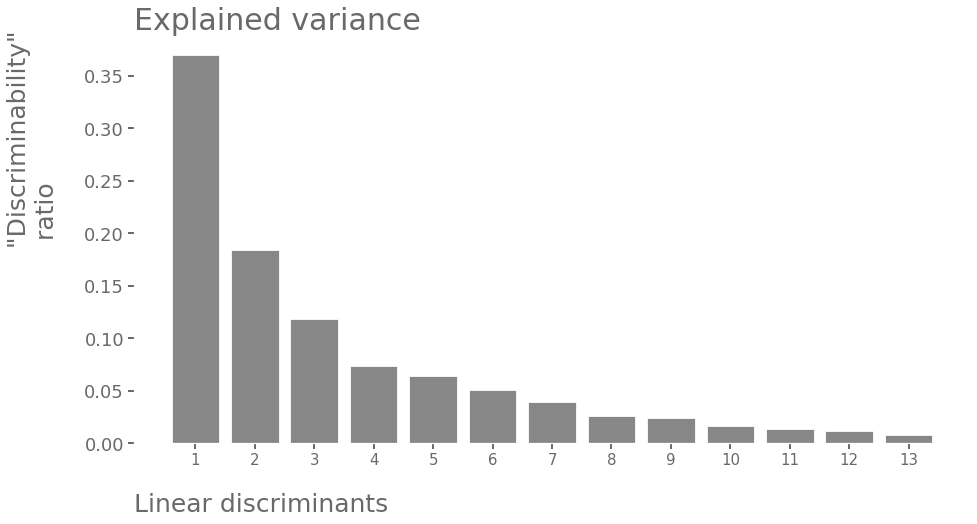

In [22]:
# LDA explained variance
total = sum(eigen_vals.real)
discr = [(i / total) for i in sorted(eigen_vals.real, reverse=True)]
cum_discr = np.cumsum(discr)

p = PrettierPlot()
ax = p.make_canvas(
    title="Explained variance",
    x_label="Linear discriminants",
    y_label='"Discriminability" \n ratio',
    y_shift=0.48,
)
p.pretty_bar_v(
    x=np.arange(1, len(discr) + 1),
    counts=discr,
    x_labels=np.arange(1, len(discr) + 1),
    y_units="fff",
    ax=ax,
)

In [23]:
# create projection matrix W
w = np.hstack(
    (eigen_pairs[0][1][:, np.newaxis].real, eigen_pairs[1][1][:, np.newaxis].real)
)
w

array([[-0.1372,  0.503 ],
       [ 0.2472,  0.1649],
       [-0.0255,  0.2446],
       [ 0.2069, -0.1135],
       [-0.1544,  0.2897],
       [-0.3938,  0.0508],
       [-0.4174, -0.0229],
       [ 0.3057,  0.0905],
       [-0.3067,  0.0084],
       [ 0.0755,  0.5498],
       [-0.3261, -0.2072],
       [-0.3686, -0.249 ],
       [-0.2967,  0.3802]])

## Projecting samples onto the new feature space

The last step is to use the transformation matrix $\textbf{W}$ to transform the training data set

<a id = 'Projecting-samples-onto-the-new-feature-space'></a>

In [24]:
# transform data set with transformation matrix W
X_train_lda = X_train_std.dot(w)
X_train_lda[:5]

array([[ 2.383 ,  0.4546],
       [-1.9658,  1.6538],
       [-2.5391,  1.0291],
       [-1.4301,  0.6024],
       [ 3.1415,  0.6621]])

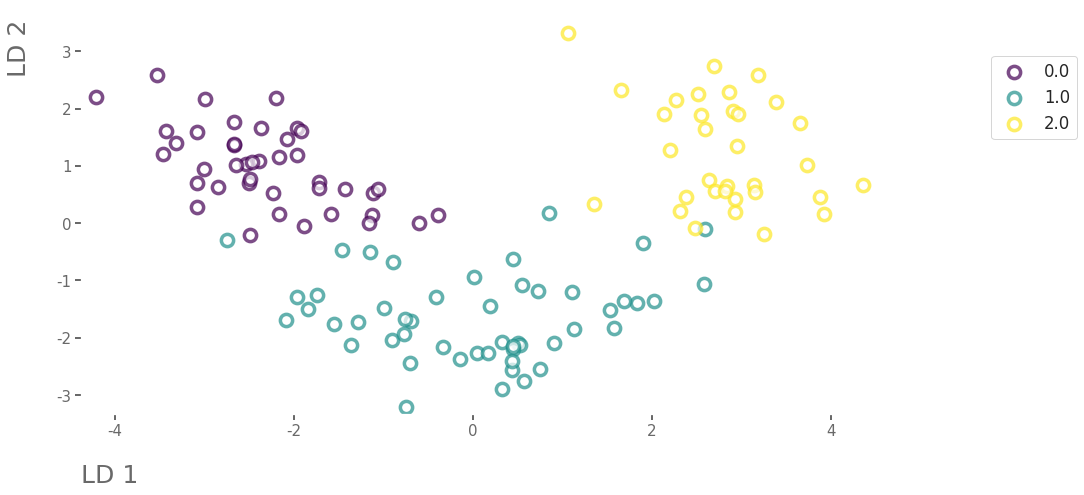

In [25]:
# visualze LDA
p = PrettierPlot()
ax = p.make_canvas(title="", x_label="LD 1", y_label="LD 2", y_shift=0.83)
p.pretty_2d_scatter_hue(
    x=X_train_lda[:, 0],
    y=X_train_lda[:, 1],
    target=y_train,
    label=np.unique(y_train),
    x_units="f",
    y_units="f",
    ax=ax,
)

## LDA in scikit-learn

<a id = 'LDA-in-scikit-learn'></a>

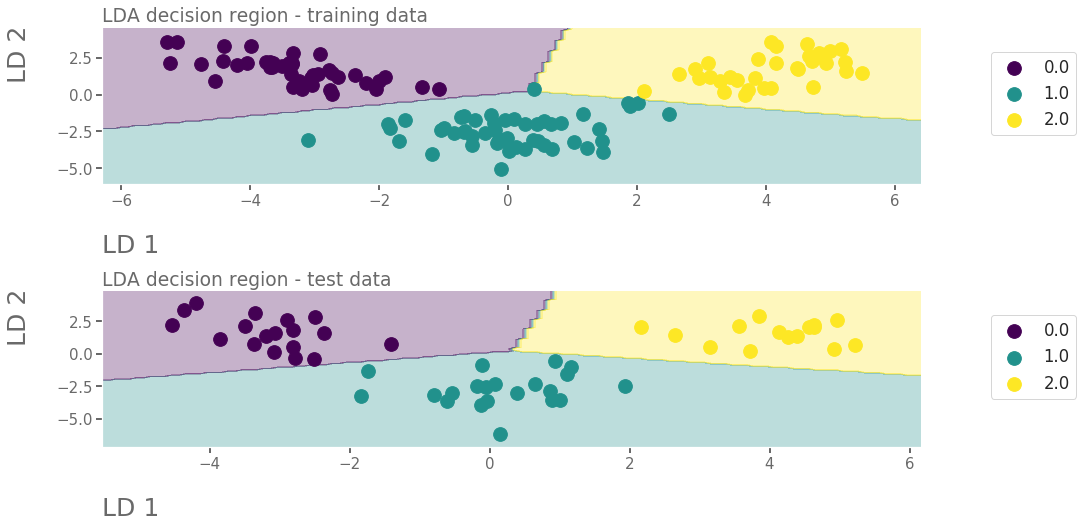

In [26]:
# perform LDA with scikit-learn
lda = discriminant_analysis.LinearDiscriminantAnalysis(n_components=2)
X_train_lda = lda.fit_transform(X_train_std, y_train)
X_test_lda = lda.transform(X_test_std)

# train regression model
lr = linear_model.LogisticRegression()
lr = lr.fit(X_train_lda, y_train)

p = PrettierPlot()
ax = p.make_canvas(
    title="LDA decision region - training data",
    x_label="LD 1",
    y_label="LD 2",
    y_shift=0.65,
    position=211,
)
p.pretty_decision_region(x=X_train_lda, y=y_train, classifier=lr, ax=ax)
ax = p.make_canvas(
    title="LDA decision region - test data",
    x_label="LD 1",
    y_label="LD 2",
    y_shift=0.65,
    position=212,
)
p.pretty_decision_region(x=X_test_lda, y=y_test, classifier=lr, ax=ax)

> Remarks - The logistic regression classifier mislabels only one sample in the training test set and perfectly separates all samples in the test set.